** Problem 1 **: *Censored data fitting* (2 points). 

$J =  \sum_{k = 1} (y_k - c^Tx_k)^2$

We want to minimize J. We can reformulate this as:

\begin{cases}
    \min \sum_{k = 1} (y_k - c^Tx_k)^2\\
    S.T. y_{M+1}..y_{K} \geq D
\end{cases}

In [138]:
import numpy as np
import scipy.io as sio
import cvxpy

n = 2 # dimension of x's
M = 3 # number of non-censored data points
K = 5 # total number of points

r = np.random.RandomState(1)
c_true = r.randn(n)
X = r.randn(n, K)
y = np.dot(X.T, c_true) + 0.1 * np.sqrt(n) * r.randn(K)

sort_ind = np.argsort(y)
X = X[:, sort_ind];
y = y[sort_ind[:M + 1]]
D = (y[M - 1] + y[M]) / 2
y = y[:M]

Y = cvxpy.Variable(K)
C = cvxpy.Variable(n)

constraints = []

for i in range(M):
    constraints.append(Y[i] == y[i])
    
for i in range(M, K):
    constraints.append(Y[i] >= D)

objective = cvxpy.Minimize(cvxpy.sum_squares(Y.T - C.T * X))

solution = cvxpy.Problem(objective, constraints)
solution.solve()

# print('Optimal value is: {0}'.format(solution.value))
print('c = \n{0}'.format(C.value))

def evaluate_solution(c_t, c):
    return np.linalg.norm(c_t  - c) / np.linalg.norm(c_t)

print('Error is {0}'.format(evaluate_solution(c_true, C.value.T)))

c = 
[[ 1.69239629]
 [-0.60648354]]
Error is 0.0393235518061


In [139]:
C = cvxpy.Variable(n)

objective = cvxpy.Minimize(cvxpy.sum_squares(y - (C.T * X[:, :M]).T))

solution = cvxpy.Problem(objective, [])
solution.solve()

# print('Optimal value is: {0}'.format(solution.value))
print('c = \n{0}'.format(C.value))

print('Error is {0}'.format(evaluate_solution(c_true, C.value.T)))

c = 
[[ 1.69240123]
 [-0.60647011]]
Error is 0.0393269890227


** Problem 2 **: *Optimal vehicle speed scheduling (3 points) *-- (additional exercise A3.20 to Boyd and Vandenberghe). 

A vehicle (say, an airplane) travels along a fixed path of *n* segments, between *n + 1* waypoints labeled *0, . . . , n*. Segment *i* starts at waypoint *i − 1* and terminates at waypoint *i*. The vehicle starts at time *t = 0* at waypoint *0*. It travels over each segment at a constant (nonnegative) speed; *si* is the speed on segment *i*. We have lower and upper limits on the speeds: *smin ≤ s ≤ smax*. The vehicle does not stop at the waypoints; it simply proceeds to the next segment. The travel distance of segment *i* is *di* (which is positive), so the travel time over segment *i* is *di/si*. We let *τi*, *i = 1, . . . , n,* denote the time at which the vehicle arrives at waypoint *i*. The vehicle is required to arrive at waypoint *i*, *for i = 1, . . . , n*, between times *τmin,i* and *τmax,i* , which are given. The vehicle consumes fuel over segment *i* at a rate that depends on its speed *Φ(s_i )=a s_i^2+b s_i+c kg/s*.

You are given the data *d* (segment travel distances), *smin* and *smax* (speed bounds), *τmin* and *τmax* (waypoint arrival time bounds), and the the parameters *a*, *b*, and *c* (all parameters are in *veh_speed_sched_data.m*). For the given form of the potentials, find the way to reduce the problem to a convex optimization problem and solve it using CVX (NB: you need not necessarily use one of the “canonical” convex optimization formulations we saw in the course). Use MATLAB command stairs to plot speed vs time for the optimal schedule.  What are relative pros and cons for using convex optimization vs. dynamic programming for such task?

$$min \sum_{i = 1}^{n} (a s_i^2+b s_i+c) \dfrac{d_i}{s_i}  $$
$$s\_min_i\leq s_i \leq s\_max_i$$
$$\tau\_min_i\leq \sum_{k=1}^{i} \dfrac{d_k}{s_k} \leq \tau\_max_i$$

In [82]:
import scipy.io as sio

mat_contents = sio.loadmat('veh_sched_data.mat')

a = mat_contents['a'][0, 0]
b = mat_contents['b'][0, 0]
c = mat_contents['c'][0, 0]
d = mat_contents['d'][:, 0]
n = mat_contents['n'][0, 0]
smin = mat_contents['smin'][:, 0]
smax = mat_contents['smax'][:, 0]
tau_min = mat_contents['tau_min'][:, 0]
tau_max = mat_contents['tau_max'][:, 0]

Optimal value is: 2617.82519352


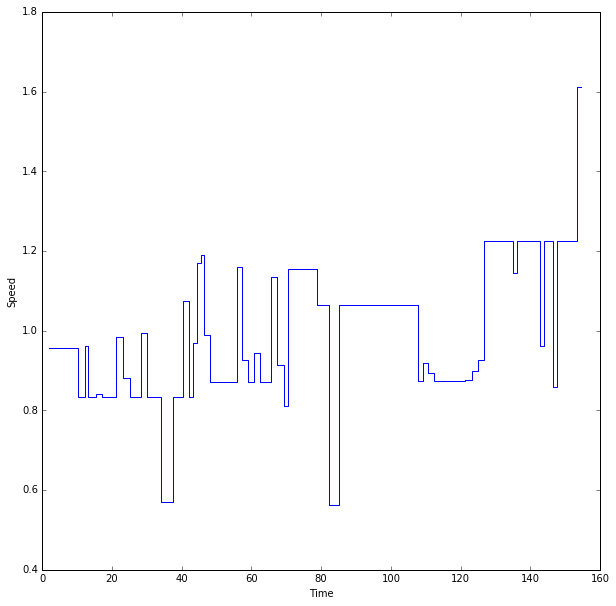

In [116]:
import cvxpy
import matplotlib.pyplot as plt
%matplotlib inline

T = cvxpy.Variable(n)

objective = a * d[0] ** 2 * cvxpy.inv_pos(T[0]) + b * d[0] + c * T[0]

constraints = []

for i in range(1, n):
    time_i = T[i] - T[i - 1]
    objective += a * d[i] ** 2 * cvxpy.inv_pos(time_i) + b * d[i] + c * time_i

    constraints.append(smin[i] * time_i <= d[i])
    constraints.append(smax[i] * time_i >= d[i])

for i in range(n):
    constraints.append(T[i] <= tau_max[i])
    constraints.append(T[i] >= tau_min[i])
    
solution = cvxpy.Problem(cvxpy.Minimize(objective), constraints)
solution.solve()

print('Optimal value is: {0}'.format(solution.value))

times = np.array(T.value)[:, 0]
speeds = [d[0] / times[0]]

for i in range(1, n):
    speeds.append(d[i] / (times[i] - times[i - 1]))

plt.figure(figsize=(10, 10))
plt.step(times, speeds)
plt.xlabel('Time')
plt.ylabel('Speed')

Pros and Cons:

Dynamic programming allows us to define the step. It gives us the opportunity to affect the time of optimisation.

Convex optimization gives more exact solution but does it in larger time.

# Problem 3

$min\ p^T x$

S.T. $$Ax \leq b$$
$$Cx = d$$

Lagrangian is: 

$$L(x, \lambda, \nu) = p^T x + \alpha^T (Ax - b) + \nu^T (d - Cx)$$

$$g(\lambda, \nu) = \min_{x} L(x, \lambda, \nu) = \min_{x} (p^T + \alpha^T A - \nu^T C)x - \alpha^T b + \nu^T d$$

Thus the dual problem fomulation is:

$$max_{\lambda, \nu} - \alpha^T b + \nu^Td$$

S.T.

$$p^T + \alpha^T A - \nu^T C = 0$$
$$\lambda \geq 0$$

# Problem 4

$$min\ x_1^2 + x_2^2 - x_1x_2$$
S.T. $$x_1 + 2x_2 \geq 1$$
$$3x_1 + x_2 \geq 1$$

The Lagrangian is:

$$L(x_1, x_2, \alpha, \nu) = x_1^2 + x_2^2 - x_1x_2 + \alpha (1 - x_1 - 2x_2) + \nu(1 - 3x_1 - x_2)$$

$$g(\alpha, \nu) = min_{x_1, x_2} L(x_1, x_2, \alpha, \nu)$$

$$\alpha, \nu \geq 0$$

$$\frac{dL(x_1, x_2, \alpha, \nu)}{\partial x_1} = 2x_1 - x_2 - \alpha - 3\nu$$

$$\frac{dL(x_1, x_2, \alpha, \nu)}{\partial x_2} = 2x_2 - x_1 - 2\alpha - \nu$$

We want to optimize L, it is convex and thus the following system of equation should hold.

\begin{cases}
    2x_1 - x_2 - \alpha - 3\nu = 0\\
    2x_2 - x_1 - 2\alpha - \nu = 0
\end{cases}

From this system we can find that:

$x_2 = \frac{5\alpha + 5\nu}{3}$

$x_1 = \frac{4\alpha}{3} + \frac{7\nu}{3}$

Now we can put this to our Lagrangian.

$$L(\alpha, \nu) = \left( \frac{4\alpha}{3} + \frac{7\nu}{3} \right)^2 + \left(\frac{5\alpha + 5\nu}{3}\right)^2 - \left(\frac{4\alpha}{3} + \frac{7\nu}{3}\right)\left(\frac{5\alpha + 5\nu}{3}\right) + \alpha \left(1 - \frac{4\alpha}{3} - \frac{7\nu}{3} - 2\left(\frac{5\alpha + 5\nu}{3}\right)\right) + \nu\left(1 - 3\left(\frac{4\alpha}{3} + \frac{7\nu}{3}\right) - \left(\frac{5\alpha + 5\nu}{3}\right)\right) = $$

$$\frac{16 \alpha^2}{9} + \frac{49 \nu^2}{9} + \frac{56 \nu \alpha}{9} + \frac{25 \alpha^2}{9} + \frac{25 \nu^2}{9} + \frac{50 \nu \alpha}{9} - \frac{20 \alpha^2}{9} - \frac{55 \alpha \nu}{9} -\frac{35 \nu^2}{9} + \alpha - \frac{4\alpha^2}{3} - \frac{7\alpha\nu}{3} - \frac{10 \alpha^2}{3} - \frac{10\alpha \nu}{3} + \nu - 4\alpha\nu - 7 \nu^2 -\frac{5\alpha \nu}{3} - \frac{5\nu^2}{3} =$$

$$-\frac{21 \alpha^2}{9} - \frac{39 \nu^2}{9} + \alpha + \nu - \frac{51 \alpha \nu}{9} = $$

$$-\frac{1}{3}\left(7 \alpha^2 + 13 \nu^2 + 17 \alpha \nu\right) + \alpha + \nu$$

In [2]:
import cvxpy
import numpy as np

X = cvxpy.Variable(2)
Q = np.array([[1, -0.5],
              [-0.5, 1]])

objective = cvxpy.Minimize(cvxpy.quad_form(X, Q))

constraints = [X[0] + 2 * X[1] >= 1, 3 * X[0] + X[1] >= 1]

solution = cvxpy.Problem(objective, constraints)
solution.solve()

print('Optimal value of initial problem is: {0}'.format(solution.value))
print('X = \n{0}'.format(X.value))

Optimal value of initial problem is: 0.107142857081
c = 
[[ 0.2857141 ]
 [ 0.35714295]]


In [4]:
import cvxpy
import numpy as np

L = cvxpy.Variable(2)
Q = np.array([[7, 8.5],
              [8.5, 13]])

objective = cvxpy.Maximize(-1 / 3.0 * cvxpy.quad_form(L, Q) + L[0] + L[1])

constraints = [L >= 0]

solution = cvxpy.Problem(objective, constraints)
solution.solve()

print('Optimal value of dual problem is: {0}'.format(solution.value))
print('lambda, nu = \n{0}'.format(L.value))

Optimal value of dual problem is: 0.107142857825
lambda, nu = 
[[  2.14287111e-01]
 [  1.17650407e-09]]


We can see that strong duality holds.

KKT conditions:

\begin{cases}
    x_1^* + 2x_2^* ≥ 1\\
    3x_1^* + x_2^* ≥ 1\\
    \lambda^*, \nu^* \geq 0\\
    \frac{d L(x^*, \alpha^*, nu^*)}{\partial x} = 0
\end{cases}

Using derivateves that were already computed it is easy to see that all the KKT conditions hold.

# Problem 5

$$\min \ c^T x$$

S.T. $$Ax \leq b$$
$$x \in \{0, 1\}$$

Thus
$$L(x, \alpha) = c^Tx + \alpha^T(Ax - b) = (c^T + \alpha^T A)x - \alpha^T b$$

$$g(\alpha) = \min_{x \in \{0, 1\}} \ L(x, \alpha) = \sum_{i} \min((c^T_i + \alpha^T a_i), 0) - \alpha^T b$$

Where $a_i$ is a i-row of matrix A. 

We want to find:

$$\max_{\alpha} \ g(\alpha)$$

S.T.

$$\alpha \geq 0$$

In [53]:
import numpy as np
import cvxpy

C = np.array([-1, -2, -4, -3])
A = np.array([[10, 0, 10, 10], [10, 10, 0, 10]])
b = np.array([15, 13])

n = C.shape[0]
m = b.shape[0]

alpha = cvxpy.Variable(m)

f = 0

for i in range(n):
    f = f - cvxpy.neg(C[i] + alpha.T * A[:, i])

f = f - alpha.T * b
objective = cvxpy.Maximize(f)

constraints = [alpha >= 0]

problem = cvxpy.Problem(objective, constraints)
problem.solve()

print('Optimal value is: {0}'.format(problem.value))
print('alpha = \n{0}'.format(alpha.value))

Optimal value is: -7.09999999583
alpha = 
[[ 0.1]
 [ 0.2]]


In [70]:
def evaluate_f(alpha):
    f = 0
    
    for i in range(n):
        f += np.min([C[i] + alpha.T.dot(A[:, i]), 0])
        
    f -= alpha.T.dot(b)
    
    return f

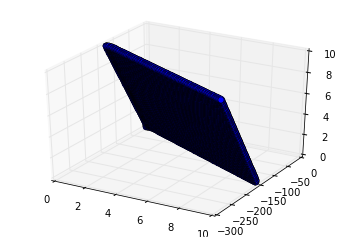

In [98]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

alpha1, alpha2 = np.meshgrid(np.arange(0, 10, 0.05), np.arange(0, 10, 0.05))

X = []
Y = []
Z = []

for i in range(alpha1.shape[0]):
    for j in range(alpha1.shape[1]):
        alpha = np.array([alpha1[i, j], alpha2[i, j]])
        f = evaluate_f(alpha)
        X.append(alpha1[i, j])
        Z.append(alpha2[i, j])
        Y.append(f)

ax.plot(X,Y,Z, ls="None", marker="o")

plt.show()